In [1]:
import torchvision
from torchvision.models import swin_t
import torch
import cv2
import torch

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name
from torchvision.transforms import transforms
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes


MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=MEAN,
                                 std=STD)

transform = transforms.Compose([
        transforms.Resize(232, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # normalize,
    ])
in_images = []
out_images = []
for image_path in imagenet_stubs.get_image_paths():
    im = PIL.Image.open(image_path).convert('RGB')
    in_images.append(im)
    im = transform(im).numpy()
    out_images.append(im)
images = np.array(out_images)

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [label_to_name(i) for i in list(predictions_["labels"].detach().numpy())]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"].detach().numpy())]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"].detach().numpy())
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 0.3
    text_th = 1
    rect_th = 1

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")


In [2]:
from torch.nn import Module

class SWIN_VIT(Module):

    def __init__(self, model, out_channels):
        super(SWIN_VIT, self).__init__()
        self.model = model
        self.model.out_channels = out_channels
        self.out_channels = out_channels


    def forward(self, x):
        f = self.model(x)
        f = f.reshape(f.shape[0], f.shape[3], f.shape[1], f.shape[2])
        return f

        
vit_model = swin_t(weights='IMAGENET1K_V1')
f_model = SWIN_VIT(vit_model.features, 768)
backbone = f_model
backbone.out_channels = 768


from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import FasterRCNN

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = MultiScaleRoIAlign(featmap_names=['0'],
                                        output_size=7,
                                        sampling_ratio=2)
model = FasterRCNN(backbone,
                   num_classes=91,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

#_ = model.eval()
'''weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model.load_state_dict(weights.get_state_dict(progress=True))
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)'''

'weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT\nmodel.load_state_dict(weights.get_state_dict(progress=True))\nmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)'

In [17]:
vit_model(test_image).detach().numpy().argmax()

NameError: name 'test_image' is not defined

In [63]:

[label_to_name(i) for i in np.argmax(predictions.detach().numpy(), axis=1)][0]

'sleeping bag'

In [30]:
vit_model_ = swin_t(weights='IMAGENET1K_V1')
predictions = vit_model_(torch.from_numpy(images))
[label_to_name(i) for i in np.argmax(predictions.detach().numpy(), axis=1)]

['sleeping bag',
 'flagpole, flagstaff',
 'mitten',
 'centipede',
 'beagle',
 'marmoset',
 'unicycle, monocycle',
 'bagel, beigel',
 'manhole cover',
 'thresher, thrasher, threshing machine',
 'gazelle',
 'rock crab, Cancer irroratus',
 'standard poodle',
 'malamute, malemute, Alaskan malamute',
 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 'notebook, notebook computer']

In [31]:

predictions = vit_model(torch.from_numpy(images))
[label_to_name(i) for i in np.argmax(predictions.detach().numpy(), axis=1)]

['apron',
 'apron',
 'apron',
 'apron',
 'apron',
 'apron',
 'apron',
 'apron',
 'apron',
 'handkerchief, hankie, hanky, hankey',
 'apron',
 'apron',
 'apron',
 'handkerchief, hankie, hanky, hankey',
 'apron',
 'handkerchief, hankie, hanky, hankey']

In [64]:
label_to_name(vit_model(test_image).detach().numpy().argmax())

'sleeping bag'

In [26]:

test_image = torch.from_numpy(images[[0]])
label_to_name(vit_model(test_image).detach().numpy().argmax())

'apron'

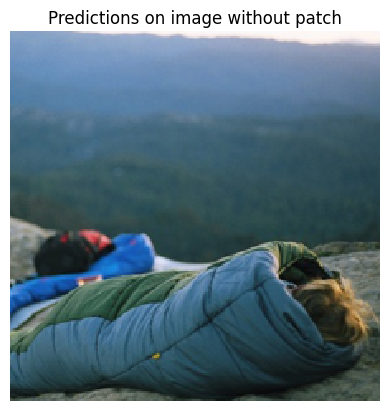

In [3]:
model.eval()
test_image = torch.from_numpy(images[[0]])
result = model(test_image)
preds = extract_predictions(result[0], 0.0000001)
im = (test_image[0]*255).numpy().transpose(1,2,0).astype(np.uint)
plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title="Predictions on image without patch")
# _ = model.train()

training model

In [3]:
import fiftyone as fo

In [5]:
# fo.Dataset.from_dir('/Users/kieranfraser/fiftyone/coco-2017-validation-100', fo.types.COCODetectionDataset)

In [4]:
coco_data = fo.zoo.load_zoo_dataset('coco-2017', split='validation', label_types=['detections'], max_samples=100)
coco_data.compute_metadata()

Found annotations at '/Users/kieranfraser/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 100/100 [232.9ms elapsed, 0s remaining, 429.4 samples/s]     
Dataset 'coco-2017-validation-100' created


In [5]:
len(coco_data.get_classes('detection'))

91

In [6]:
# session = fo.launch_app(coco_data)
from vision.utils import FiftyOneTorchDataset

In [8]:
'''import torch
import fiftyone.utils.coco as fouc
from PIL import Image


class FiftyOneTorchDataset(torch.utils.data.Dataset):
    """A class to construct a PyTorch dataset from a FiftyOne dataset.
    
    Args:
        fiftyone_dataset: a FiftyOne dataset or view that will be used for training or testing
        transforms (None): a list of PyTorch transforms to apply to images and targets when loading
        gt_field ("ground_truth"): the name of the field in fiftyone_dataset that contains the 
            desired labels to load
        classes (None): a list of class strings that are used to define the mapping between
            class names and indices. If None, it will use all classes present in the given fiftyone_dataset.
    """

    def __init__(
        self,
        filepaths,
        labels,
        metadata,
        detections,
        transforms=None,
        classes=None,
    ):
        self.filepaths = filepaths
        self.labels = labels
        self.metadata = metadata
        self.detections = detections
        self.transforms = transforms

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = labels

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        meta = self.metadata[idx]
        detections = self.detections[idx]
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        area = []
        iscrowd = []
        for det in detections:
            category_id = self.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_label(
                det, meta, category_id=category_id,
            )
            x, y, w, h = coco_obj.bbox
            boxes.append([x, y, x + w, y + h])
            labels.append(coco_obj.category_id)
            area.append(coco_obj.area)
            iscrowd.append(coco_obj.iscrowd)

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.as_tensor([idx])
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.filepaths)

    def get_classes(self):
        return self.classes'''


In [7]:
# Import functions from the torchvision references we cloned
from vision.engine import train_one_epoch, evaluate
import vision.utils as utils

def do_training(model, torch_dataset, torch_dataset_test, num_epochs=4):
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)
    
    data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

In [8]:
# From the torchvision references we cloned
import vision.transforms as T

train_transforms = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(0.5)])
test_transforms = T.Compose([T.ToTensor()])

In [9]:
# split the dataset in train and test set
train_view = coco_data.take(80, seed=51)
test_view = coco_data.exclude([s.id for s in train_view])

In [25]:
'''def convert_detections(d):
    detections = []
    if d is not None and 'detections' in d:
        for i in d.detections:
            tmp = dict(i.to_dict())
            tmp.pop('_id')
            detections.append(tmp)
    return detections

class MetaData():
    def __init__(self, item):
        self.width = item['width']
        self.height = item['height']
    
    def width(self):
        return self.width

    def height(self):
        return self.height'''

In [10]:
train_metadata = [train_view[i].metadata for i in train_view.values("filepath")]
print('working on groundtruth')
train_detections = [train_view[i].ground_truth['detections'] for i in train_view.values("filepath")]
print('working on filepaths')
train_filepaths = train_view.values('filepath')
print('working on detections')
train_classes = train_view.distinct('ground_truth.detections.label')

print('working on test..')

test_metadata = [test_view[i].metadata for i in test_view.values("filepath")]
test_detections = [test_view[i].ground_truth['detections'] for i in test_view.values("filepath")]
test_filepaths = test_view.values('filepath')
test_classes = test_view.distinct('ground_truth.detections.label')

working on groundtruth
working on filepaths
working on detections
working on test..


In [11]:
torch_dataset = FiftyOneTorchDataset(train_filepaths,train_classes,train_metadata,train_detections,transforms=train_transforms,
        classes=train_view.get_classes('detections'))
torch_dataset_test = FiftyOneTorchDataset(test_filepaths,test_classes, test_metadata, test_detections,transforms=test_transforms,
        classes=test_view.get_classes('detections'))

In [12]:
do_training(model, torch_dataset, torch_dataset_test, num_epochs=3)

Using device cpu
Epoch: [0]  [ 0/40]  eta: 0:05:48  lr: 0.000133  loss: 6.2592 (6.2592)  loss_classifier: 4.6340 (4.6340)  loss_box_reg: 0.1147 (0.1147)  loss_objectness: 0.7985 (0.7985)  loss_rpn_box_reg: 0.7119 (0.7119)  time: 8.7068  data: 3.0818  max mem: 0
Epoch: [0]  [10/40]  eta: 0:02:59  lr: 0.001414  loss: 5.3445 (5.0455)  loss_classifier: 4.1397 (3.7865)  loss_box_reg: 0.1147 (0.1140)  loss_objectness: 0.7179 (0.6761)  loss_rpn_box_reg: 0.4171 (0.4689)  time: 5.9815  data: 0.2808  max mem: 0
Epoch: [0]  [20/40]  eta: 0:01:55  lr: 0.002695  loss: 2.6709 (3.4781)  loss_classifier: 1.4596 (2.3012)  loss_box_reg: 0.1097 (0.1359)  loss_objectness: 0.5157 (0.5684)  loss_rpn_box_reg: 0.4526 (0.4727)  time: 5.6382  data: 0.0007  max mem: 0
Epoch: [0]  [30/40]  eta: 0:00:57  lr: 0.003975  loss: 1.4401 (2.7448)  loss_classifier: 0.4366 (1.6974)  loss_box_reg: 0.1097 (0.1307)  loss_objectness: 0.3968 (0.5024)  loss_rpn_box_reg: 0.4497 (0.4143)  time: 5.5630  data: 0.0007  max mem: 0
Epo

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Test:  [ 0/20]  eta: 0:00:57  model_time: 0.7723 (0.7723)  evaluator_time: 0.0012 (0.0012)  time: 2.8718  data: 2.0981  max mem: 0
Test:  [19/20]  eta: 0:00:00  model_time: 0.7070 (0.7178)  evaluator_time: 0.0005 (0.0006)  time: 0.8239  data: 0.1053  max mem: 0
Test: Total time: 0:00:26 (1.3245 s / it)
Averaged stats: model_time: 0.7070 (0.7178)  evaluator_time: 0.0005 (0.0006)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Test:  [ 0/20]  eta: 0:01:01  model_time: 0.8034 (0.8034)  evaluator_time: 0.0010 (0.0010)  time: 3.0653  data: 2.2608  max mem: 0
Test:  [19/20]  eta: 0:00:00  model_time: 0.7743 (0.7703)  evaluator_time: 0.0005 (0.0006)  time: 0.8845  data: 0.1135  max mem: 0
Test: Total time: 0:00:27 (1.3847 s / it)
Averaged stats: model_time: 0.7743 (0.7703)  evaluator_time: 0.0005 (0.0006)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Test:  [ 0/20]  eta: 0:00:57  model_time: 0.7627 (0.7627)  evaluator_time: 0.0010 (0.0010)  time: 2.8599  data: 2.0962  max mem: 0
Test:  [19/20]  eta: 0:00:00  model_time: 0.7141 (0.7275)  evaluator_time: 0.0005 (0.0005)  time: 0.8334  data: 0.1052  max mem: 0
Test: Total time: 0:00:26 (1.3338 s / it)
Averaged stats: model_time: 0.7141 (0.7275)  evaluator_time: 0.0005 (0.0005)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]

In [58]:
data_loader = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

In [59]:
for img, target in data_loader:
    print(img)
    break

(tensor([[[0.4863, 0.4941, 0.4941,  ..., 0.6745, 0.6627, 0.6627],
         [0.4941, 0.4980, 0.4941,  ..., 0.6745, 0.6667, 0.6667],
         [0.4980, 0.5020, 0.4980,  ..., 0.6706, 0.6667, 0.6667],
         ...,
         [0.6510, 0.7804, 0.8039,  ..., 0.2431, 0.3608, 0.3216],
         [0.6510, 0.8157, 0.8510,  ..., 0.2275, 0.2588, 0.4078],
         [0.6510, 0.8863, 0.8471,  ..., 0.3294, 0.3255, 0.3725]],

        [[0.4588, 0.4627, 0.4627,  ..., 0.7922, 0.7882, 0.7882],
         [0.4667, 0.4667, 0.4627,  ..., 0.7922, 0.7922, 0.7922],
         [0.4745, 0.4706, 0.4667,  ..., 0.7961, 0.7922, 0.7922],
         ...,
         [0.6510, 0.7059, 0.7922,  ..., 0.2980, 0.4235, 0.3647],
         [0.6706, 0.7255, 0.8275,  ..., 0.2824, 0.3020, 0.4196],
         [0.5686, 0.8275, 0.8078,  ..., 0.3569, 0.3490, 0.3882]],

        [[0.3843, 0.3882, 0.3882,  ..., 0.9412, 0.9373, 0.9373],
         [0.3922, 0.3843, 0.3882,  ..., 0.9412, 0.9412, 0.9412],
         [0.3882, 0.3882, 0.3843,  ..., 0.9451, 0.9412, 0

In [63]:
img, target = torch_dataset.__getitem__(1)

In [44]:
label_to_name(vit_model(torch.unsqueeze(img, dim=0)).argmax().item())

'apron'

In [55]:
img.numpy().max()

1.0

In [66]:
torch_dataset.__getitem__(0)

(tensor([[[0.7098, 0.7137, 0.7137,  ..., 0.6588, 0.6667, 0.6980],
          [0.7098, 0.7098, 0.7137,  ..., 0.6706, 0.7725, 0.7529],
          [0.7098, 0.7098, 0.7098,  ..., 0.8706, 0.8510, 0.8745],
          ...,
          [0.3216, 0.2980, 0.2784,  ..., 0.1255, 0.2549, 0.4627],
          [0.3176, 0.2980, 0.2824,  ..., 0.1843, 0.3451, 0.5255],
          [0.3137, 0.3059, 0.2941,  ..., 0.2510, 0.4471, 0.5725]],
 
         [[0.7098, 0.7137, 0.7137,  ..., 0.6196, 0.6275, 0.6431],
          [0.7098, 0.7098, 0.7137,  ..., 0.6588, 0.6549, 0.6471],
          [0.7098, 0.7098, 0.7098,  ..., 0.7647, 0.7647, 0.7882],
          ...,
          [0.1686, 0.1412, 0.1216,  ..., 0.0667, 0.1412, 0.3020],
          [0.1569, 0.1373, 0.1176,  ..., 0.1059, 0.2118, 0.3451],
          [0.1412, 0.1255, 0.1137,  ..., 0.1529, 0.2824, 0.3725]],
 
         [[0.7098, 0.7137, 0.7137,  ..., 0.6118, 0.5922, 0.6314],
          [0.7098, 0.7098, 0.7137,  ..., 0.6392, 0.6471, 0.5804],
          [0.7098, 0.7098, 0.7098,  ...,

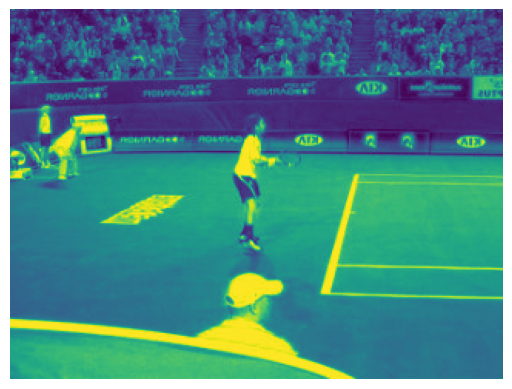

In [64]:
plt.figure()
plt.axis("off")
plt.imshow(img[0].transpose(), )

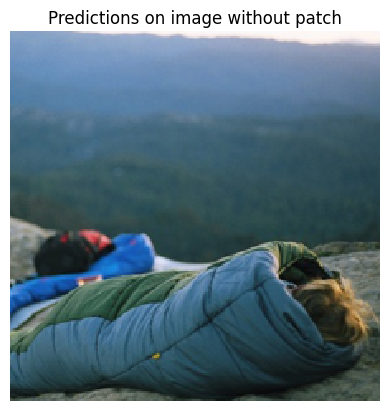

In [15]:
model.eval()
test_image = torch.from_numpy(images[[0]])
result = model(test_image)
preds = extract_predictions(result[0], 0.0000001)
im = (test_image[0]*255).numpy().transpose(1,2,0).astype(np.uint)
plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title="Predictions on image without patch")

Example attack demonstrating reduced performance

Different backbones and prediction head

In [35]:
len(coco_data.get_classes('detections'))

91